# Data Input and Processing

In [1]:
import pandas as pd
import glob

# Load the main files
games_df = pd.read_csv('nfl-big-data-bowl-2025/games.csv')
plays_df = pd.read_csv('nfl-big-data-bowl-2025/plays.csv')
players_df = pd.read_csv('nfl-big-data-bowl-2025/players.csv')
player_play_df = pd.read_csv('nfl-big-data-bowl-2025/player_play.csv')

# Merge games and plays on gameId
game_play_df = pd.merge(games_df, plays_df, on='gameId', how='inner')

# Merge with player_play data on gameId and playId
game_play_player_play_df = pd.merge(game_play_df, player_play_df, on=['gameId', 'playId'], how='inner')

## 10-team Dataset

In [10]:
columns_to_keep = ['gameId', 'playId', 'quarter', 'down', 'yardsToGo', 'possessionTeam', 'defensiveTeam', 
                   'yardlineNumber', 'yardlineSide','gameClock', 'preSnapHomeScore', 'preSnapVisitorScore',
                   'absoluteYardlineNumber', 'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 
                  'offenseFormation', 'receiverAlignment', 'passResult', 'rushLocationType']

In [12]:
import pandas as pd

# List of teams to include
teams_to_include = ['ATL', 'CHI', 'PHI', 'BAL', 'WAS', 'GB', 'JAX', 'MIA', 'NYG', 'CLE'] #['ATL', 'CHI', 'PHI', 'KC']
columns_to_encode = ['yardlineSide', 'offenseFormation', 'receiverAlignment']
# Initialize an empty list to store filtered data
filtered_team_data = []

# Iterate through the teams and process each team's plays
def process_team_plays():
    for team in teams_to_include:
        # Filter the plays DataFrame for the current team
        team_df = plays_df[plays_df['possessionTeam'] == team]

        # Retain only the necessary columns
        team_df = team_df[columns_to_keep]

        # Add the 'playType' column based on 'passResult'
        team_df['playType'] = team_df['passResult'].apply(
            lambda x: 'run' if pd.isnull(x) else 'pass'
        )

        # Create 'rushLocationType_clean' column
        team_df['rushLocationType_clean'] = team_df.apply(
            lambda row: 'PASS' if row['playType'] == 'pass' and pd.isnull(row['rushLocationType']) else row['rushLocationType'],
            axis=1
        )

        # Replace null values with 'Unknown' in specific columns
        team_df[columns_to_encode] = team_df[columns_to_encode].fillna('Unknown')

        # Update 'playType' based on certain conditions
        team_df['playType'] = team_df.apply(
            lambda row: 'Unknown' if row['offenseFormation'] == 'Unknown' and row['rushLocationType'] == 'UNKNOWN' else row['playType'],
            axis=1
        )

        # Remove rows where 'rushLocationType_clean' is 'UNKNOWN'
        team_df = team_df[team_df['rushLocationType_clean'] != 'UNKNOWN']

        # Append processed DataFrame to the list
        filtered_team_data.append(team_df)

    # Combine the processed DataFrames into one
    global temp_df
    temp_df = pd.concat(filtered_team_data, ignore_index=True)

# Call the function to process plays
process_team_plays()

# Display the resulting DataFrame or save it as needed
print(temp_df.tail())
# temp_df.to_csv("filtered_plays_data.csv", index=False)  # Uncomment to save as a CSV


          gameId  playId  quarter  down  yardsToGo possessionTeam  \
5147  2022102300    2842        4     1         10            CLE   
5148  2022103100    3041        4     1         10            CLE   
5149  2022091801    3416        4     1         10            CLE   
5150  2022101601    3722        4     3          5            CLE   
5151  2022103100    2428        3     1         10            CLE   

     defensiveTeam  yardlineNumber yardlineSide gameClock  ...  \
5147           BAL              47          CLE     10:34  ...   
5148           CIN              35          CLE     11:56  ...   
5149           NYJ              45          NYJ     06:49  ...   
5150            NE              15           NE     06:25  ...   
5151           CIN              40          CLE     07:27  ...   

      preSnapVisitorScore  absoluteYardlineNumber  \
5147                   13                      63   
5148                    6                      75   
5149                   17    

In [14]:
# Step 1: Score Differential
temp_df['scoreDifferential'] = temp_df['preSnapHomeScore'] - temp_df['preSnapVisitorScore']
temp_df['isLeading'] = (temp_df['scoreDifferential'] > 0).astype(int)

# Step 2: Field Position
temp_df['isRedZone'] = (temp_df['absoluteYardlineNumber'] <= 20).astype(int)

# Step 3: Down and Distance
temp_df['shortYardage'] = (temp_df['yardsToGo'] <= 3).astype(int)
temp_df['secondAndLong'] = ((temp_df['down'] == 2) & (temp_df['yardsToGo'] > 8)).astype(int)
temp_df['thirdAndLong'] = ((temp_df['down'] == 3) & (temp_df['yardsToGo'] > 7)).astype(int)

# Step 4: Game Context
temp_df['fourthQuarter'] = (temp_df['quarter'] == 4).astype(int)
temp_df['twoMinuteDrill'] = ((temp_df['quarter'] == 4) & (temp_df['gameClock'].str.split(':').str[0].astype(int) <= 2)).astype(int)

temp_df = temp_df.drop(columns=['passResult', 'rushLocationType', 'playType'])

In [16]:
import pandas as pd
import glob

# List of teams to include
teams_to_include = ['ATL', 'CHI', 'PHI', 'BAL', 'WAS', 'GB', 'JAX', 'MIA', 'NYG', 'CLE'] #['ATL', 'CHI', 'PHI', 'KC']

# File path pattern for all weekly files
file_pattern = "nfl-big-data-bowl-2025/tracking_week_*.csv"

# List to store each filtered DataFrame
filtered_dataframes = []

# Loop through each file that matches the pattern
for file in glob.glob(file_pattern):
    # Read the CSV file
    df = pd.read_csv(file)

    # Filter the DataFrame to only include rows where club is in the specified teams
    df_filtered = df[df['club'].isin(teams_to_include)]

    # Append the filtered data to the list
    filtered_dataframes.append(df_filtered)

# Concatenate all filtered DataFrames into a single DataFrame
combined_df_tracking = pd.concat(filtered_dataframes, ignore_index=True)

# Display or save the final DataFrame
print(combined_df_tracking.head())
# combined_df_tracking.to_csv("combined_tracking_data.csv", index=False)  # Uncomment to save as a CSV

combined_df_tracking = combined_df_tracking[combined_df_tracking['frameType'] == 'BEFORE_SNAP']
temp_df_track = combined_df_tracking

       gameId  playId    nflId      displayName  frameId    frameType  \
0  2022100913      55  33131.0  Calais Campbell        1  BEFORE_SNAP   
1  2022100913      55  33131.0  Calais Campbell        2  BEFORE_SNAP   
2  2022100913      55  33131.0  Calais Campbell        3  BEFORE_SNAP   
3  2022100913      55  33131.0  Calais Campbell        4  BEFORE_SNAP   
4  2022100913      55  33131.0  Calais Campbell        5  BEFORE_SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-10-10 00:23:13.4          93.0  BAL          left  83.35  29.02  0.05   
1  2022-10-10 00:23:13.5          93.0  BAL          left  83.34  29.03  0.06   
2  2022-10-10 00:23:13.6          93.0  BAL          left  83.34  29.04  0.09   
3  2022-10-10 00:23:13.7          93.0  BAL          left  83.33  29.04  0.13   
4  2022-10-10 00:23:13.8          93.0  BAL          left  83.33  29.05  0.14   

      a   dis       o     dir                 event  
0  0.05  0.02  103.1

## KC-only dataset

In [19]:
# Data Pre-processing
# Create the 'playType' column
kc_temp_df = plays_df[plays_df['possessionTeam'] == 'KC']
kc_temp_df = kc_temp_df[columns_to_keep]
kc_temp_df['playType'] = kc_temp_df['passResult'].apply(lambda x: 'run' if pd.isnull(x) else 'pass')
print(kc_temp_df[['passResult', 'playType']].head())

# Create the 'rushLocationType_clean' column
kc_temp_df['rushLocationType_clean'] = kc_temp_df.apply(
    lambda row: 'PASS' if row['playType'] == 'pass' and pd.isnull(row['rushLocationType']) else row['rushLocationType'],
    axis=1
)
print(kc_temp_df[['playType', 'rushLocationType', 'rushLocationType_clean']].head())

# List of columns to encode nulls as 'Unknown'
columns_to_encode = ['yardlineSide', 'offenseFormation', 'receiverAlignment']

# Replace null values with 'Unknown' in the specified columns
kc_temp_df[columns_to_encode] = kc_temp_df[columns_to_encode].fillna('Unknown')

# Update 'playType' based on the condition
kc_temp_df['playType'] = kc_temp_df.apply(
    lambda row: 'Unknown' if row['offenseFormation'] == 'Unknown' and row['rushLocationType'] == 'UNKNOWN' else row['playType'],
    axis=1
)

# will drop rows where 'rushLocationType_clean = 'Unknown'

kc_temp_df = kc_temp_df[kc_temp_df['rushLocationType_clean'] != 'UNKNOWN']


    passResult playType
3            C     pass
87         NaN      run
105          C     pass
111          C     pass
116          C     pass
    playType rushLocationType rushLocationType_clean
3       pass              NaN                   PASS
87       run    OUTSIDE_RIGHT          OUTSIDE_RIGHT
105     pass              NaN                   PASS
111     pass              NaN                   PASS
116     pass              NaN                   PASS


In [21]:
# Step 1: Score Differential
kc_temp_df['scoreDifferential'] = kc_temp_df['preSnapHomeScore'] - kc_temp_df['preSnapVisitorScore']
kc_temp_df['isLeading'] = (kc_temp_df['scoreDifferential'] > 0).astype(int)

# Step 2: Field Position
kc_temp_df['isRedZone'] = (kc_temp_df['absoluteYardlineNumber'] <= 20).astype(int)

# Step 3: Down and Distance
kc_temp_df['shortYardage'] = (kc_temp_df['yardsToGo'] <= 3).astype(int)
kc_temp_df['secondAndLong'] = ((kc_temp_df['down'] == 2) & (kc_temp_df['yardsToGo'] > 8)).astype(int)
kc_temp_df['thirdAndLong'] = ((kc_temp_df['down'] == 3) & (kc_temp_df['yardsToGo'] > 7)).astype(int)

# Step 4: Game Context
kc_temp_df['fourthQuarter'] = (kc_temp_df['quarter'] == 4).astype(int)
kc_temp_df['twoMinuteDrill'] = (
    (kc_temp_df['quarter'] == 4) & 
    (kc_temp_df['gameClock'].str.split(':').str[0].astype(int) <= 2)
).astype(int)

kc_temp_df = kc_temp_df.drop(columns=['passResult', 'rushLocationType', 'playType'])


In [76]:
kc_temp_df = kc_temp_df[kc_temp_df['rushLocationType_clean'] != 'PASS']

In [62]:
import pandas as pd
import glob

# File path pattern for all weekly files
file_pattern = "nfl-big-data-bowl-2025/tracking_week_*.csv"

# List to store each filtered DataFrame
filtered_dataframes = []

# Loop through each file that matches the pattern
for file in glob.glob(file_pattern):
    # Read the CSV file
    df = pd.read_csv(file)
    
    # Filter the DataFrame to only include rows where club is 'ATL'
    df_kc_tracking = df[df['club'] == 'KC']
    
    # Append the filtered data to the list
    filtered_dataframes.append(df_kc_tracking)

# Concatenate all filtered DataFrames into a single DataFrame
combined_df_kc_tracking = pd.concat(filtered_dataframes, ignore_index=True)

# Display or save the final DataFrame
print(combined_df_kc_tracking.head())
# combined_df_atl_tracking.to_csv("combined_tracking_data.csv", index=False)  # Uncomment to save as a CSV

combined_df_kc_tracking = combined_df_kc_tracking[combined_df_kc_tracking['frameType'] == 'BEFORE_SNAP']
kc_temp_df_track = combined_df_kc_tracking


       gameId  playId    nflId  displayName  frameId    frameType  \
0  2022101000      57  42406.0  Frank Clark        1  BEFORE_SNAP   
1  2022101000      57  42406.0  Frank Clark        2  BEFORE_SNAP   
2  2022101000      57  42406.0  Frank Clark        3  BEFORE_SNAP   
3  2022101000      57  42406.0  Frank Clark        4  BEFORE_SNAP   
4  2022101000      57  42406.0  Frank Clark        5  BEFORE_SNAP   

                    time  jerseyNumber club playDirection      x      y     s  \
0  2022-10-11 00:15:50.4          55.0   KC         right  40.59  25.43  1.46   
1  2022-10-11 00:15:50.5          55.0   KC         right  40.54  25.57  1.50   
2  2022-10-11 00:15:50.6          55.0   KC         right  40.48  25.73  1.58   
3  2022-10-11 00:15:50.7          55.0   KC         right  40.43  25.90  1.63   
4  2022-10-11 00:15:50.8          55.0   KC         right  40.37  26.06  1.64   

      a   dis       o     dir                 event  
0  0.78  0.15  342.67  339.31  huddle_break_

# EDA

In [140]:
import pandas as pd

# Columns to retain
columns_to_keep = ['gameId', 'playId', 'possessionTeam', 'yardlineSide', 
                   'offenseFormation', 'receiverAlignment', 'passResult', 'rushLocationType']

# Function to process plays for all teams
def process_all_teams():
    # Retain only necessary columns
    eda_df = plays_df[columns_to_keep]

    # Add 'playType' column based on 'passResult'
    eda_df['playType'] = eda_df['passResult'].apply(
        lambda x: 'run' if pd.isnull(x) else 'pass'
    )

    return eda_df

# Process the data for all teams
eda_df = process_all_teams()

# Display the resulting DataFrame
print(eda_df.tail())
# eda_df.to_csv("filtered_plays_data.csv", index=False)  # Uncomment to save as a CSV


           gameId  playId possessionTeam yardlineSide offenseFormation  \
16119  2022110604    1051            JAX          JAX          SHOTGUN   
16120  2022103005    3492            MIN          MIN          SHOTGUN   
16121  2022092502    2337             KC          IND          SHOTGUN   
16122  2022091809     719            DAL          CIN       SINGLEBACK   
16123  2022101602    3046            NYJ           GB       SINGLEBACK   

      receiverAlignment passResult rushLocationType playType  
16119               2x2          I              NaN     pass  
16120               2x2          I              NaN     pass  
16121               2x2          R     INSIDE_RIGHT     pass  
16122               2x2          I              NaN     pass  
16123               3x1        NaN      INSIDE_LEFT      run  


/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/182422014.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eda_df['playType'] = eda_df['passResult'].apply(


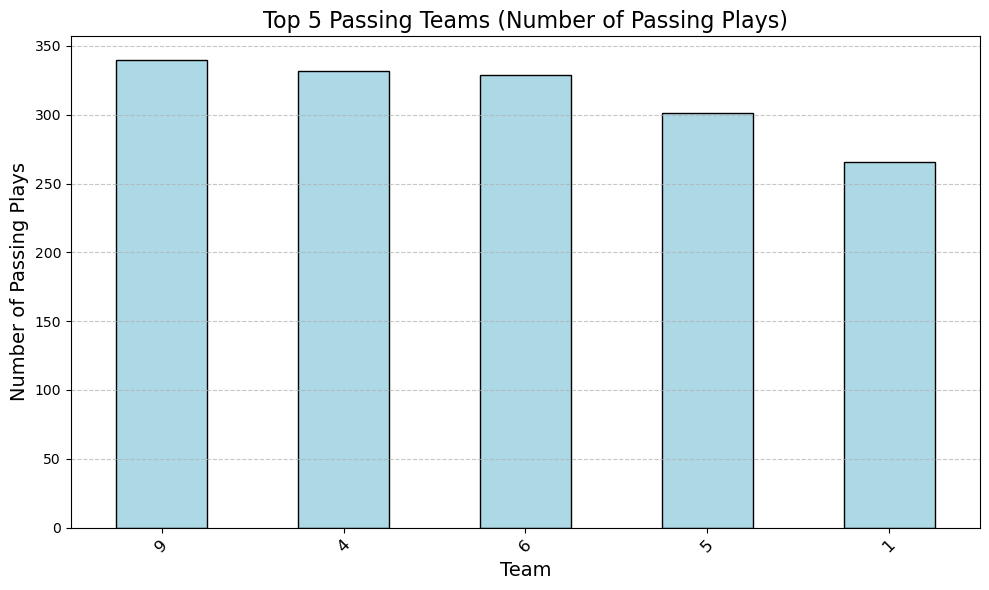

In [150]:
import matplotlib.pyplot as plt

# Plot the bar chart for passing teams using your specified code
plt.figure(figsize=(10, 6))
temp_df[temp_df['rushLocationType_clean'] == 'PASS']['possessionTeam'].value_counts().head(5).plot(
    kind='bar', color='lightblue', edgecolor='black'
)
plt.title("Top 5 Passing Teams (Number of Passing Plays)", fontsize=16)
plt.xlabel("Team", fontsize=14)
plt.ylabel("Number of Passing Plays", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

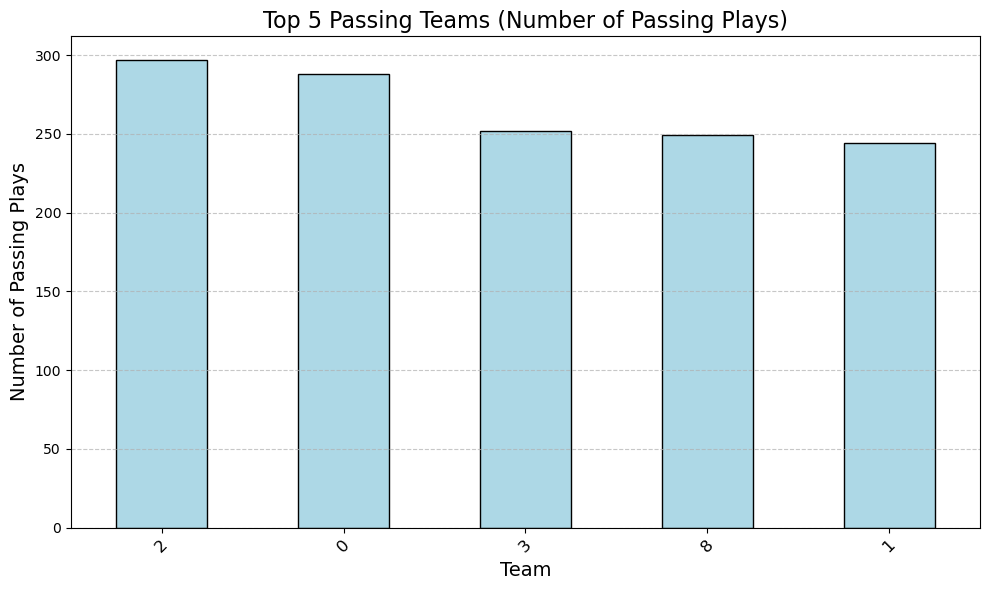

In [152]:
import matplotlib.pyplot as plt

# Plot the bar chart for passing teams using your specified code
plt.figure(figsize=(10, 6))
temp_df[temp_df['rushLocationType_clean'] != 'PASS']['possessionTeam'].value_counts().head(5).plot(
    kind='bar', color='lightblue', edgecolor='black'
)
plt.title("Top 5 Passing Teams (Number of Passing Plays)", fontsize=16)
plt.xlabel("Team", fontsize=14)
plt.ylabel("Number of Passing Plays", fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# 1) Grouped bar chart for total runs by 'rushLocationType' (top 10) for 'ATL', 'CHI', 'PHI'
rush_location_counts = rush_df.groupby(['possessionTeam', 'rushLocationType']).size().unstack().fillna(0)
rush_location_top10 = rush_location_counts.sum().nlargest(10).index  # Select top 10
rush_location_counts = rush_location_counts[rush_location_top10]      # Filter for top 10 locations

rush_location_counts.T.plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Rush Locations by Team')
plt.xlabel('Rush Location Type')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Filter data for the specified teams
rush_df = plays_df[plays_df['possessionTeam'].isin(['ATL', 'CHI', 'PHI'])]

# 1) Grouped bar chart for total runs by 'rushLocationType' (top 10) for 'ATL', 'CHI', 'PHI'
rush_location_counts = rush_df.groupby(['possessionTeam', 'rushLocationType']).size().unstack().fillna(0)
rush_location_top10 = rush_location_counts.sum().nlargest(10).index  # Select top 10
rush_location_counts = rush_location_counts[rush_location_top10]      # Filter for top 10 locations

rush_location_counts.T.plot(kind='bar', figsize=(12, 6))
plt.title('Top 10 Rush Locations by Team')
plt.xlabel('Rush Location Type')
plt.ylabel('Total Runs')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# KC Models

## KC Random Forest PCA Classifier

/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/243171622.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_temp_df['rushLocationType_clean'] = kc_temp_df['rushLocationType_clean'].fillna('PASS')
/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/243171622.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_temp_df['target_encoded'] = label_encoder.fit_transform(kc_temp_df['rushLocationType_clean'])
/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/243171


Classification Report:

               precision    recall  f1-score   support

  INSIDE_LEFT       0.43      0.46      0.44        13
 INSIDE_RIGHT       0.38      0.25      0.30        12
 OUTSIDE_LEFT       0.44      0.67      0.53         6
OUTSIDE_RIGHT       0.60      0.60      0.60         5

     accuracy                           0.44        36
    macro avg       0.46      0.49      0.47        36
 weighted avg       0.44      0.44      0.43        36

Test Accuracy: 0.4444


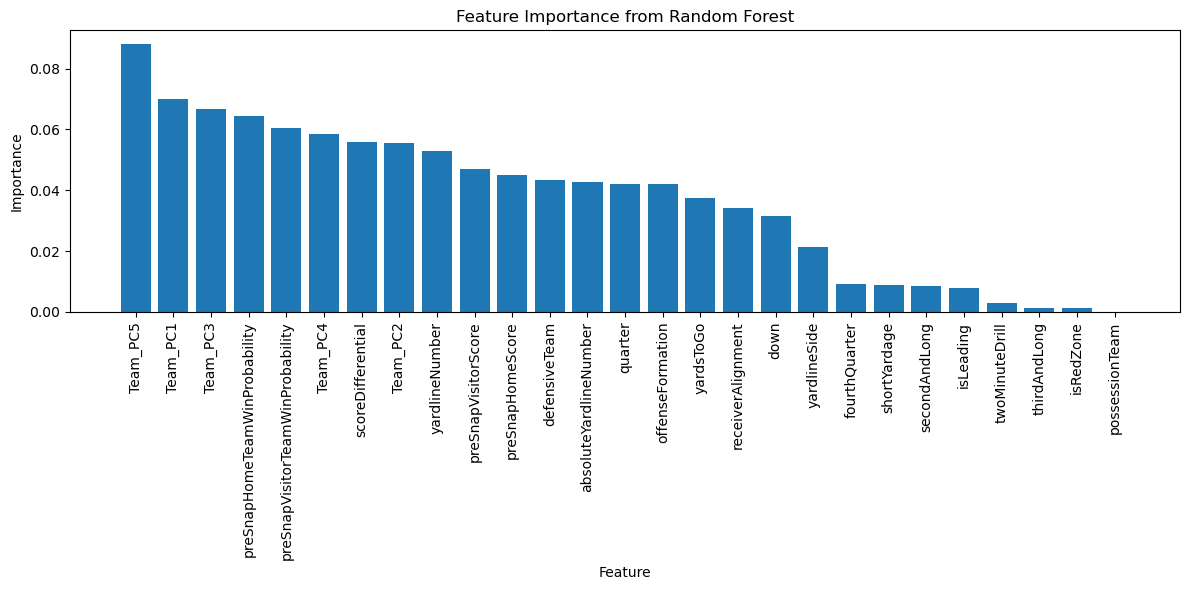


Top Features:

                             Feature  Importance
26                          Team_PC5    0.088160
22                          Team_PC1    0.069877
24                          Team_PC3    0.066864
10     preSnapHomeTeamWinProbability    0.064304
11  preSnapVisitorTeamWinProbability    0.060517
25                          Team_PC4    0.058538
14                 scoreDifferential    0.055945
23                          Team_PC2    0.055667
5                     yardlineNumber    0.053049
8                preSnapVisitorScore    0.047113


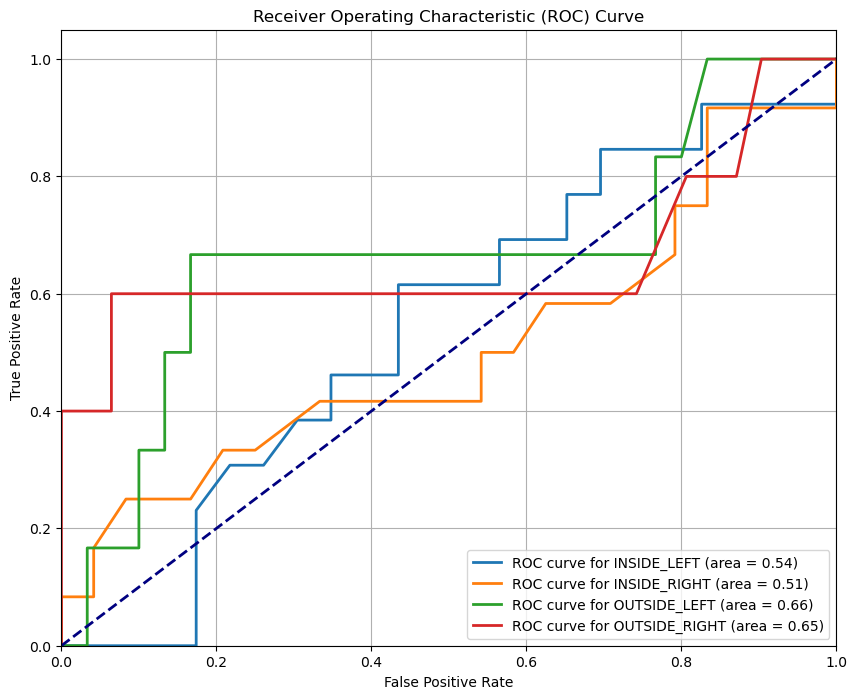

In [80]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Preprocess Play-Level Data
# Replace NA values in 'rushLocationType_clean' with 'PASS' for pass plays
kc_temp_df['rushLocationType_clean'] = kc_temp_df['rushLocationType_clean'].fillna('PASS')

# Encode target variable
label_encoder = LabelEncoder()
kc_temp_df['target_encoded'] = label_encoder.fit_transform(kc_temp_df['rushLocationType_clean'])

# Select categorical and numeric features for play-level data
categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

# Label encode categorical variables
for feature in categorical_features:
    kc_temp_df[feature] = LabelEncoder().fit_transform(kc_temp_df[feature])

# Normalize numeric features
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
scaler = StandardScaler()
kc_temp_df[numeric_to_normalize] = scaler.fit_transform(kc_temp_df[numeric_to_normalize])

# Combine processed features
play_X_prepared = kc_temp_df[categorical_features + numeric_features].values
play_y_prepared = kc_temp_df['target_encoded']

# Step 2: Perform PCA on Tracking Data
# Define the number of principal components
n_components = 5

# Select relevant tracking features
tracking_features = ['x', 'y', 's', 'a', 'dir']

# Filter tracking data for valid plays
valid_plays = set(kc_temp_df[['gameId', 'playId']].apply(tuple, axis=1))

if not valid_plays:
    raise ValueError("No valid plays found in kc_temp_df. Please check the input data.")

filtered_tracking = kc_temp_df_track[kc_temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]

if filtered_tracking.empty:
    raise ValueError("Filtered tracking data is empty. Ensure that kc_temp_df_track contains matching gameId and playId pairs.")

# Perform PCA directly on the tracking data
pca = PCA(n_components=n_components)

# Check if there are enough rows for PCA
if len(filtered_tracking) < n_components:
    raise ValueError(f"Not enough samples ({len(filtered_tracking)}) for PCA with {n_components} components.")

team_tracking_pca = pca.fit_transform(filtered_tracking[tracking_features].fillna(0))  # Handle NaN by filling with 0

# Create DataFrame for PCA components
team_tracking_df = pd.DataFrame(team_tracking_pca, columns=[f'Team_PC{i+1}' for i in range(n_components)])
team_tracking_df[['gameId', 'playId']] = filtered_tracking[['gameId', 'playId']].values

# Aggregate PCA components by play (mean)
aggregated_tracking = team_tracking_df.groupby(['gameId', 'playId']).mean().reset_index()

# Merge aggregated tracking data with play-level data
play_tracking_merged = kc_temp_df.merge(aggregated_tracking, on=['gameId', 'playId'])



# Step 3: Prepare Features and Target
X = play_tracking_merged.drop(columns=['rushLocationType_clean', 'target_encoded', 'gameClock', 'gameId', 'playId'])
y = play_tracking_merged['target_encoded']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.fillna(0), y_train)  # Handle NaN by filling with 0

# Step 6: Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Step 7: Evaluate the Model
# Predict on the test set
y_pred = rf_classifier.predict(X_test.fillna(0))  # Handle NaN by filling with 0

# Classification report with category names
categories = label_encoder.inverse_transform(np.unique(y))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Feature Importance
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Debugging: Display top important features
print("\nTop Features:\n")
print(importance_df.head(10))

# Step 9: Plot ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.arange(len(categories)))
y_score = rf_classifier.predict_proba(X_test.fillna(0))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {category} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


## XGBoost Models

/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/1378248173.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_temp_df['rushLocationType_clean'] = kc_temp_df['rushLocationType_clean'].fillna('PASS')
/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/1378248173.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_temp_df['target_encoded'] = label_encoder.fit_transform(kc_temp_df['rushLocationType_clean'])
/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/1378


Classification Report:

               precision    recall  f1-score   support

  INSIDE_LEFT       0.33      0.31      0.32        13
 INSIDE_RIGHT       0.31      0.33      0.32        12
 OUTSIDE_LEFT       0.43      0.50      0.46         6
OUTSIDE_RIGHT       0.75      0.60      0.67         5

     accuracy                           0.39        36
    macro avg       0.45      0.44      0.44        36
 weighted avg       0.40      0.39      0.39        36

Test Accuracy: 0.3889


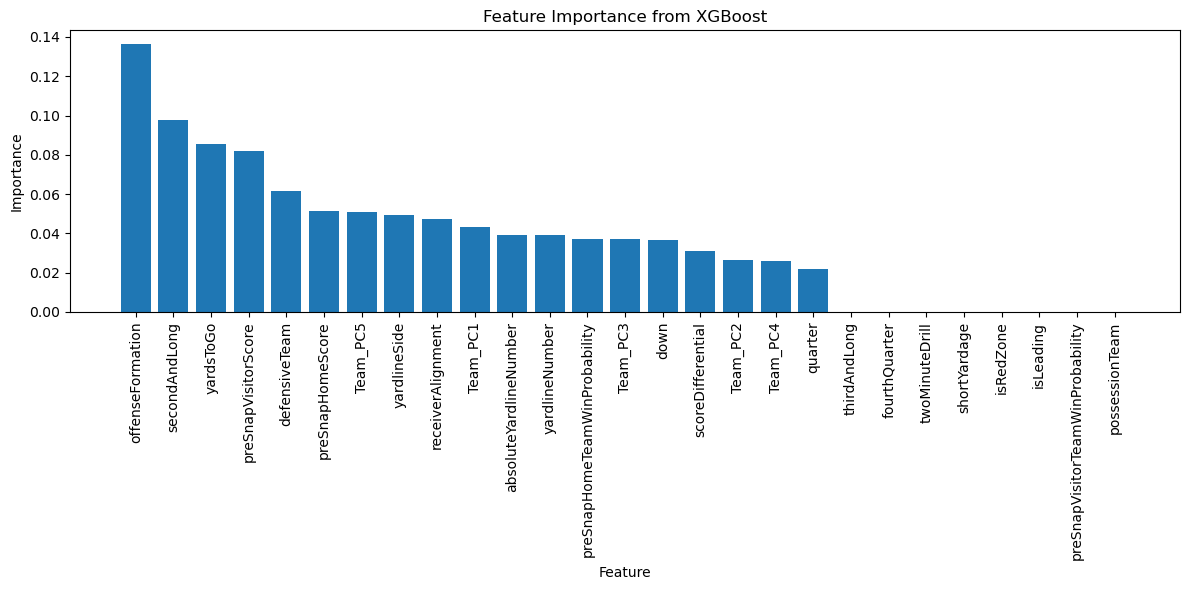


Top Features:

                Feature  Importance
12     offenseFormation    0.136563
18        secondAndLong    0.097943
2             yardsToGo    0.085293
8   preSnapVisitorScore    0.081742
4         defensiveTeam    0.061400
7      preSnapHomeScore    0.051608
26             Team_PC5    0.050856
6          yardlineSide    0.049325
13    receiverAlignment    0.047483
22             Team_PC1    0.043355


In [82]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Step 1: Preprocess Play-Level Data
# Replace NA values in 'rushLocationType_clean' with 'PASS' for pass plays
kc_temp_df['rushLocationType_clean'] = kc_temp_df['rushLocationType_clean'].fillna('PASS')

# Encode target variable
label_encoder = LabelEncoder()
kc_temp_df['target_encoded'] = label_encoder.fit_transform(kc_temp_df['rushLocationType_clean'])

# Select categorical and numeric features for play-level data
categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

# Label encode categorical variables
for feature in categorical_features:
    kc_temp_df[feature] = LabelEncoder().fit_transform(kc_temp_df[feature])

# Normalize numeric features
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
scaler = StandardScaler()
kc_temp_df[numeric_to_normalize] = scaler.fit_transform(kc_temp_df[numeric_to_normalize])

# Combine processed features
play_X_prepared = kc_temp_df[categorical_features + numeric_features].values
play_y_prepared = kc_temp_df['target_encoded']

# Step 2: Perform PCA on Tracking Data
# Define the number of principal components
n_components = 5

# Select relevant tracking features
tracking_features = ['x', 'y', 's', 'a', 'dir']

# Filter tracking data for valid plays
valid_plays = set(kc_temp_df[['gameId', 'playId']].apply(tuple, axis=1))
filtered_tracking = kc_temp_df_track[kc_temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]

if filtered_tracking.empty:
    raise ValueError("Filtered tracking data is empty. Ensure kc_temp_df_track contains matching gameId and playId pairs.")

# Perform PCA directly
pca = PCA(n_components=n_components)
team_tracking_pca = pca.fit_transform(filtered_tracking[tracking_features].fillna(0))  # Handle NaN by filling with 0

# Create DataFrame for PCA components
team_tracking_df = pd.DataFrame(team_tracking_pca, columns=[f'Team_PC{i+1}' for i in range(n_components)])
team_tracking_df[['gameId', 'playId']] = filtered_tracking[['gameId', 'playId']].values

# Aggregate PCA components by play (mean)
aggregated_tracking = team_tracking_df.groupby(['gameId', 'playId']).mean().reset_index()

# Merge aggregated tracking data with play-level data
play_tracking_merged = kc_temp_df.merge(aggregated_tracking, on=['gameId', 'playId'])

# Step 3: Prepare Features and Target
X = play_tracking_merged.drop(columns=['rushLocationType_clean', 'target_encoded', 'gameClock', 'gameId', 'playId'])
y = play_tracking_merged['target_encoded']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.fillna(0), y_train)  # Handle NaN by filling with 0

# Step 6: Train XGBoost Classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Step 7: Evaluate the Model
# Predict on the test set
y_pred = xgb_classifier.predict(X_test.fillna(0))  # Handle NaN by filling with 0

# Classification report with category names
categories = label_encoder.inverse_transform(np.unique(y))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Feature Importance
feature_importances = xgb_classifier.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance from XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Debugging: Display top important features
print("\nTop Features:\n")
print(importance_df.head(10))


## GRU

In [88]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Concatenate, Dropout, Masking
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

# Step 1: Preprocess play-level data
kc_temp_df['rushLocationType_clean'] = kc_temp_df['rushLocationType_clean'].fillna('PASS')
label_encoder = LabelEncoder()
kc_temp_df['target_encoded'] = label_encoder.fit_transform(kc_temp_df['rushLocationType_clean'])

categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

for feature in categorical_features:
    kc_temp_df[feature] = LabelEncoder().fit_transform(kc_temp_df[feature])

scaler = StandardScaler()
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
kc_temp_df[numeric_to_normalize] = scaler.fit_transform(kc_temp_df[numeric_to_normalize])

play_X_prepared = kc_temp_df[categorical_features + numeric_features].values
play_y_prepared = kc_temp_df['target_encoded']

# Step 2: Prepare tracking data with percentile-based sequence length
tracking_features = ['x', 'y', 's', 'a', 'dir']

valid_plays = set(kc_temp_df[['gameId', 'playId']].apply(tuple, axis=1))
filtered_tracking = kc_temp_df_track[kc_temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]

if filtered_tracking.empty:
    raise ValueError("Filtered tracking data is empty. Ensure kc_temp_df_track contains matching gameId and playId pairs.")

# Determine the 95th percentile for sequence length
play_lengths = filtered_tracking.groupby(['gameId', 'playId']).size()
sequence_length = int(play_lengths.quantile(0.95))
print(f"Using sequence length: {sequence_length}")

# Downsample longer plays
def downsample_play(play_data, target_length):
    if len(play_data) > target_length:
        factor = len(play_data) / target_length
        return play_data[::int(factor)]
    return play_data

# Group and process plays for tracking data
grouped_tracking = filtered_tracking.groupby(['gameId', 'playId']).apply(
    lambda group: downsample_play(group[tracking_features].values, sequence_length)
)

# Pad sequences to the new fixed sequence length
tracking_sequences = [
    np.pad(seq, ((0, max(0, sequence_length - len(seq))), (0, 0)), mode='constant')[:sequence_length]
    for seq in grouped_tracking
]
tracking_X_prepared = np.array(tracking_sequences)

# Match targets to tracking data
tracking_targets = kc_temp_df.set_index(['gameId', 'playId']).loc[grouped_tracking.index]['target_encoded']
tracking_y_prepared = tracking_targets.values

# Step 3: Use focal loss for class imbalance
import tensorflow as tf

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        ce_loss = CategoricalCrossentropy()(y_true, y_pred)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        return alpha * modulating_factor * ce_loss
    return loss

# One-hot encode targets
play_y_prepared = to_categorical(play_y_prepared)
tracking_y_prepared = to_categorical(tracking_y_prepared)

# Split data into training and testing sets
play_X_train, play_X_test, tracking_X_train, tracking_X_test, y_train, y_test = train_test_split(
    play_X_prepared, tracking_X_prepared, play_y_prepared, test_size=0.2, random_state=42
)

# Step 4: Define the GRU-based neural network with masking
play_input = Input(shape=(play_X_train.shape[1],), name="Play_Input")
play_dense = Dense(64, activation="relu")(play_input)

tracking_input = Input(shape=(sequence_length, len(tracking_features)), name="Tracking_Input")
masked_tracking_input = Masking(mask_value=0)(tracking_input)  # Mask padding
tracking_gru = GRU(64, return_sequences=False)(masked_tracking_input)
tracking_dense = Dense(32, activation="relu")(tracking_gru)

combined = Concatenate()([play_dense, tracking_dense])

dense_1 = Dense(64, activation="relu")(combined)
dense_2 = Dense(32, activation="relu")(dense_1)
dropout = Dropout(0.3)(dense_2)
output = Dense(play_y_prepared.shape[1], activation="softmax")(dropout)

model = Model(inputs=[play_input, tracking_input], outputs=output)
model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])

# Step 5: Train the model
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    [play_X_train, tracking_X_train], y_train,
    validation_data=([play_X_test, tracking_X_test], y_test),
    epochs=50, batch_size=32, callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate([play_X_test, tracking_X_test], y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
y_pred = np.argmax(model.predict([play_X_test, tracking_X_test]), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))


/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/1617922665.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_temp_df['rushLocationType_clean'] = kc_temp_df['rushLocationType_clean'].fillna('PASS')
/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/1617922665.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kc_temp_df['target_encoded'] = label_encoder.fit_transform(kc_temp_df['rushLocationType_clean'])
/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/1617

Using sequence length: 1498
Epoch 1/50


/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/1617922665.py:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_tracking = filtered_tracking.groupby(['gameId', 'playId']).apply(
/opt/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['Play_Input', 'Tracking_Input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.2413 - loss: 0.2227 - val_accuracy: 0.3056 - val_loss: 0.1595
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step - accuracy: 0.3779 - loss: 0.1641 - val_accuracy: 0.2500 - val_loss: 0.1699
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 255ms/step - accuracy: 0.3682 - loss: 0.1634 - val_accuracy: 0.2500 - val_loss: 0.1758
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 408ms/step - accuracy: 0.4517 - loss: 0.1496 - val_accuracy: 0.2500 - val_loss: 0.1784
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 314ms/step - accuracy: 0.4053 - loss: 0.1546 - val_accuracy: 0.2222 - val_loss: 0.1769
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.3955 - loss: 0.1502 - val_accuracy: 0.2500 - val_loss: 0.1775
Test Accuracy: 0.3056
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step

Classification Report:

               precision    recall  f1-score   support

  INSIDE_LEFT       0.27      1.00      0.43         9
 INSIDE_RIGHT       0.67      0.11      0.19        18
 OU

/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## KC Baseline Classifiers

In [84]:
from sklearn.dummy import DummyClassifier

# Use a random strategy for classification
random_baseline = DummyClassifier(strategy="uniform", random_state=42)
random_baseline.fit(X_train, y_train)
random_y_pred = random_baseline.predict(X_test)

# Evaluate the random baseline
print("Random Baseline Classification Report:")
print(classification_report(y_test, random_y_pred, target_names=label_encoder.classes_))

Random Baseline Classification Report:
               precision    recall  f1-score   support

  INSIDE_LEFT       0.50      0.31      0.38        13
 INSIDE_RIGHT       0.75      0.50      0.60        12
 OUTSIDE_LEFT       0.44      0.67      0.53         6
OUTSIDE_RIGHT       0.09      0.20      0.12         5

     accuracy                           0.42        36
    macro avg       0.45      0.42      0.41        36
 weighted avg       0.52      0.42      0.44        36



In [86]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Naive Bayes classifier
naive_bayes_classifier = GaussianNB()

# Fit the classifier on the training data
naive_bayes_classifier.fit(X_train, y_train)

# Predict on the test data
naive_bayes_y_pred = naive_bayes_classifier.predict(X_test)

# Evaluate the model
print("Naive Bayes Classification Report:")
print(classification_report(y_test, naive_bayes_y_pred, target_names=label_encoder.classes_))

# Calculate accuracy
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_y_pred)
print(f"Naive Bayes Test Accuracy: {naive_bayes_accuracy:.4f}")


Naive Bayes Classification Report:
               precision    recall  f1-score   support

  INSIDE_LEFT       0.00      0.00      0.00        13
 INSIDE_RIGHT       0.57      0.33      0.42        12
 OUTSIDE_LEFT       0.22      1.00      0.36         6
OUTSIDE_RIGHT       0.50      0.20      0.29         5

     accuracy                           0.31        36
    macro avg       0.32      0.38      0.27        36
 weighted avg       0.30      0.31      0.24        36

Naive Bayes Test Accuracy: 0.3056


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# 10-team Models

## Random Forest Classifier

Test Accuracy: 0.5296

Classification Report:

               precision    recall  f1-score   support

  INSIDE_LEFT       0.27      0.10      0.15       141
 INSIDE_RIGHT       0.22      0.12      0.16       144
 OUTSIDE_LEFT       0.20      0.07      0.11        97
OUTSIDE_RIGHT       0.15      0.06      0.09       102
         PASS       0.61      0.92      0.73       547

     accuracy                           0.53      1031
    macro avg       0.29      0.25      0.25      1031
 weighted avg       0.42      0.53      0.45      1031

Random Forest Classifier AUC Score (Macro-Averaged): 0.6353


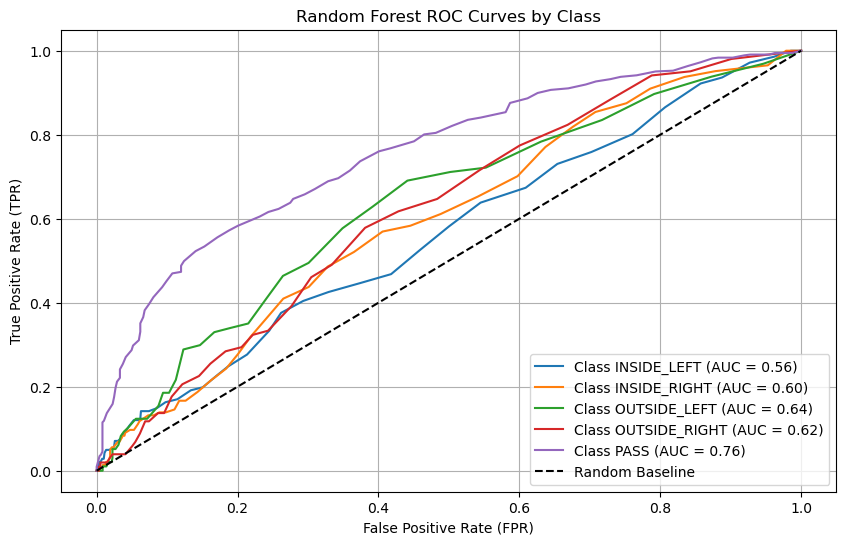


10-Fold Cross-Validation Results:
Mean Accuracy: 0.5208
Standard Deviation: 0.0107

Feature Importances:

                             Feature  Importance
12  preSnapVisitorTeamWinProbability    0.114064
11     preSnapHomeTeamWinProbability    0.113594
10                    yardlineNumber    0.113518
3                      defensiveTeam    0.076885
4                       yardlineSide    0.074171
13                 scoreDifferential    0.062929
8                   preSnapHomeScore    0.057960
6                          yardsToGo    0.057523
2                     possessionTeam    0.055180
9                preSnapVisitorScore    0.053691
0                   offenseFormation    0.048237
1                  receiverAlignment    0.047549
7                            quarter    0.034274
5                               down    0.031668
19                     fourthQuarter    0.010804
17                     secondAndLong    0.009987
16                      shortYardage    0.009983
14         

In [94]:
# Baseline RF Classifier

import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Step 1: Preprocess play-level data
# Replace NA values in 'rushLocationType_clean' with 'PASS' for pass plays
temp_df['rushLocationType_clean'] = temp_df['rushLocationType_clean'].fillna('PASS')

# Encode target variable
label_encoder = LabelEncoder()
temp_df['target_encoded'] = label_encoder.fit_transform(temp_df['rushLocationType_clean'])

# Select categorical and numeric features for play-level data
categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

# Label encode categorical variables
for feature in categorical_features:
    temp_df[feature] = LabelEncoder().fit_transform(temp_df[feature])

# Normalize numeric features
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
scaler = StandardScaler()
temp_df[numeric_to_normalize] = scaler.fit_transform(temp_df[numeric_to_normalize])

# Combine processed features
X = temp_df[categorical_features + numeric_features].values
y = temp_df['target_encoded']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Train a Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train, y_train)

# Step 3: Evaluate the model
# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Generate classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Step 4: ROC-AUC Score
# Binarize the labels for multi-class ROC calculation
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = rf_classifier.predict_proba(X_test)

# Calculate AUC score (macro average for multi-class)
auc_score = roc_auc_score(y_test_binarized, y_pred_proba, average='macro', multi_class='ovr')
print(f"Random Forest Classifier AUC Score (Macro-Averaged): {auc_score:.4f}")

# Plot ROC Curves for each class
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Random Forest ROC Curves by Class")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Step 5: K-Fold Cross-Validation
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf_classifier, X, y, cv=kfold, scoring='accuracy')

print("\n10-Fold Cross-Validation Results:")
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Step 6: Feature Importance
feature_importances = pd.DataFrame({
    'Feature': categorical_features + numeric_features,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:\n")
print(feature_importances)


Explained Variance by PCA Components: [9.42577805e-01 5.36005656e-02 3.72095856e-03 8.34030645e-05
 1.72677333e-05]

Classification Report:

               precision    recall  f1-score   support

  INSIDE_LEFT       0.20      0.15      0.17       141
 INSIDE_RIGHT       0.23      0.14      0.17       144
 OUTSIDE_LEFT       0.13      0.09      0.11        97
OUTSIDE_RIGHT       0.16      0.11      0.13       102
         PASS       0.62      0.80      0.70       547

     accuracy                           0.48      1031
    macro avg       0.27      0.26      0.26      1031
 weighted avg       0.42      0.48      0.44      1031

Test Accuracy: 0.4821


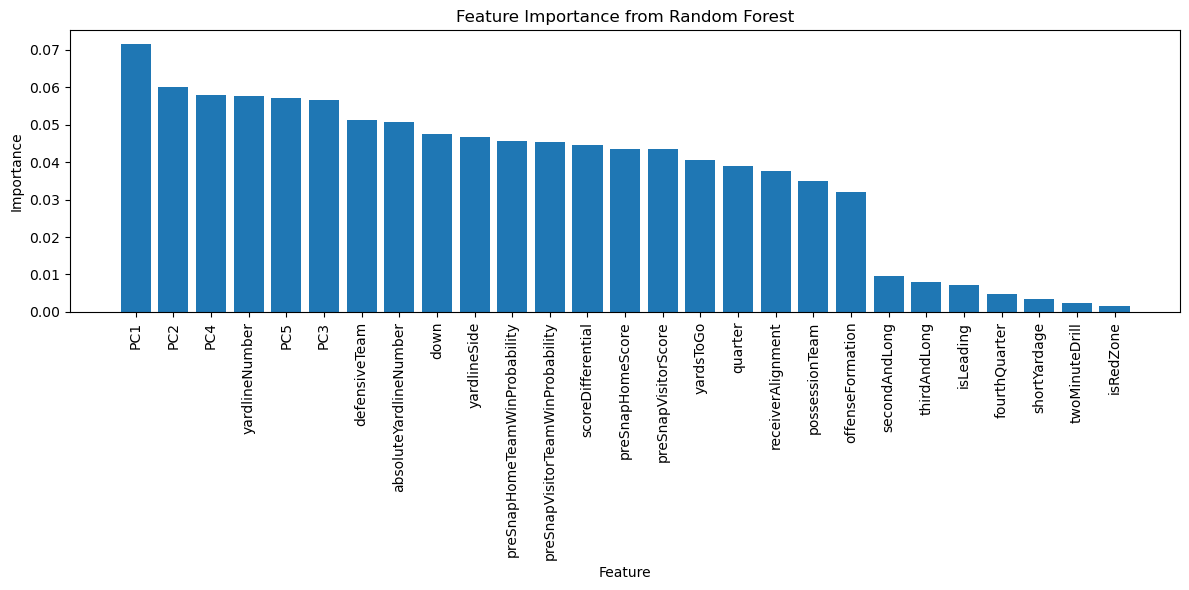


Top Features:

                   Feature  Importance
22                     PC1    0.071579
23                     PC2    0.059939
25                     PC4    0.057784
5           yardlineNumber    0.057533
26                     PC5    0.057051
24                     PC3    0.056646
4            defensiveTeam    0.051120
9   absoluteYardlineNumber    0.050611
1                     down    0.047574
6             yardlineSide    0.046659
Random Forest Classifier AUC Score (Macro-Averaged): 0.6279


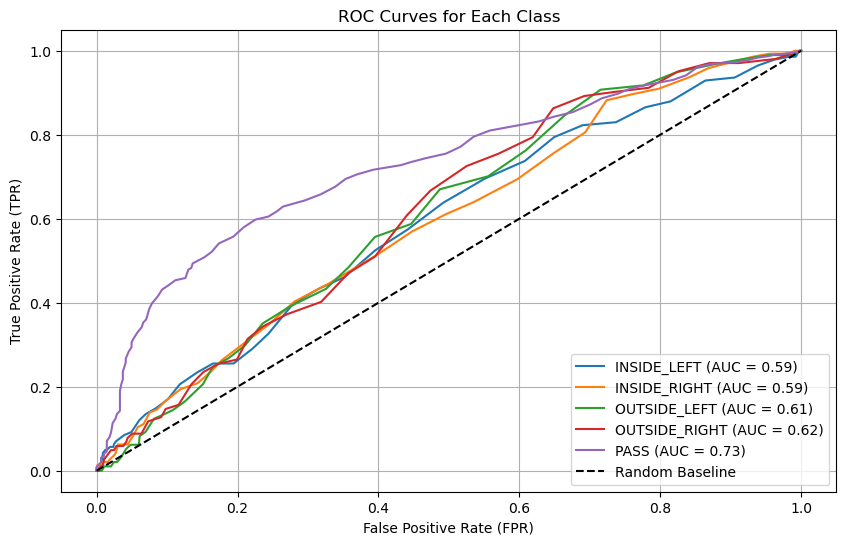

In [130]:
# RF Classifier with PCA (Updated for Missing Values)
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Preprocess play-level data
temp_df['rushLocationType_clean'] = temp_df['rushLocationType_clean'].fillna('PASS')
label_encoder = LabelEncoder()
temp_df['target_encoded'] = label_encoder.fit_transform(temp_df['rushLocationType_clean'])

categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

for feature in categorical_features:
    temp_df[feature] = LabelEncoder().fit_transform(temp_df[feature])

numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
scaler = StandardScaler()
temp_df[numeric_to_normalize] = scaler.fit_transform(temp_df[numeric_to_normalize])

# Fill missing values with 0 before preparing features
temp_df = temp_df.fillna(0)

play_X_prepared = temp_df[categorical_features + numeric_features].values
play_y_prepared = temp_df['target_encoded']

# Step 2: Preprocess Tracking Data with PCA
n_components = 5
tracking_features = ['x', 'y', 's', 'a', 'dir']
valid_plays = set(temp_df[['gameId', 'playId']].apply(tuple, axis=1))
filtered_tracking = temp_df_track[temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]

# Fill missing values in tracking data with 0 before PCA
filtered_tracking = filtered_tracking.fillna(0)

pca = PCA(n_components=n_components)
tracking_X_pca = pca.fit_transform(filtered_tracking[tracking_features])
print(f"Explained Variance by PCA Components: {pca.explained_variance_ratio_}")

filtered_tracking['play_id_tuple'] = filtered_tracking[['gameId', 'playId']].apply(tuple, axis=1)
tracking_pca_df = pd.DataFrame(tracking_X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
tracking_pca_df['play_id_tuple'] = filtered_tracking['play_id_tuple'].values

aggregated_tracking = tracking_pca_df.groupby('play_id_tuple').mean().reset_index()
aggregated_tracking[['gameId', 'playId']] = pd.DataFrame(aggregated_tracking['play_id_tuple'].tolist(), index=aggregated_tracking.index)
aggregated_tracking = aggregated_tracking.drop(columns=['play_id_tuple'])

play_tracking_merged = temp_df.merge(aggregated_tracking, on=['gameId', 'playId'])

# Step 3: Prepare Features and Target
X = play_tracking_merged.drop(columns=['rushLocationType_clean', 'target_encoded', 'gameClock', 'gameId', 'playId'])
y = play_tracking_merged['target_encoded']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 6: Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Step 7: Evaluate the Model
y_pred = rf_classifier.predict(X_test)
categories = label_encoder.inverse_transform(np.unique(y))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))

accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Feature Importance
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()
print("\nTop Features:\n")
print(importance_df.head(10))

# Step 9: Compute and Plot ROC-AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = rf_classifier.predict_proba(X_test)
auc_score = roc_auc_score(y_test_binarized, y_pred_proba, average="macro", multi_class="ovr")
print(f"Random Forest Classifier AUC Score (Macro-Averaged): {auc_score:.4f}")

plt.figure(figsize=(10, 6))
for i, class_name in enumerate(categories):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc_score(y_test_binarized[:, i], y_pred_proba[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curves for Each Class")
plt.legend(loc="lower right")
plt.grid()
plt.show()


/var/folders/xq/zt1b259x609_m4jtvlr5gfsw0000gn/T/ipykernel_3488/149460297.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_tracking['club'] = LabelEncoder().fit_transform(filtered_tracking['club'])



Classification Report:

               precision    recall  f1-score   support

  INSIDE_LEFT       0.37      0.27      0.31       186
 INSIDE_RIGHT       0.32      0.25      0.28       189
 OUTSIDE_LEFT       0.36      0.25      0.29       126
OUTSIDE_RIGHT       0.32      0.20      0.24       133
         PASS       0.68      0.85      0.75       717

     accuracy                           0.56      1351
    macro avg       0.41      0.36      0.38      1351
 weighted avg       0.52      0.56      0.53      1351

Test Accuracy: 0.5648


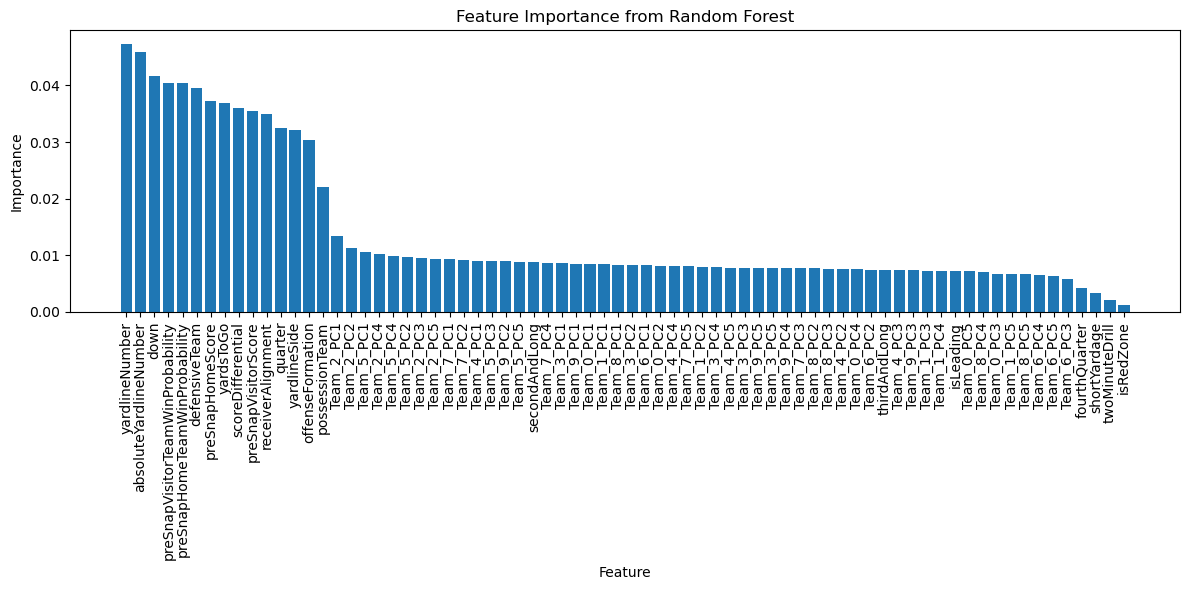


Top Features:

                             Feature  Importance
5                     yardlineNumber    0.047358
9             absoluteYardlineNumber    0.045973
1                               down    0.041670
11  preSnapVisitorTeamWinProbability    0.040421
10     preSnapHomeTeamWinProbability    0.040403
4                      defensiveTeam    0.039558
7                   preSnapHomeScore    0.037264
2                          yardsToGo    0.036926
14                 scoreDifferential    0.035978
8                preSnapVisitorScore    0.035555


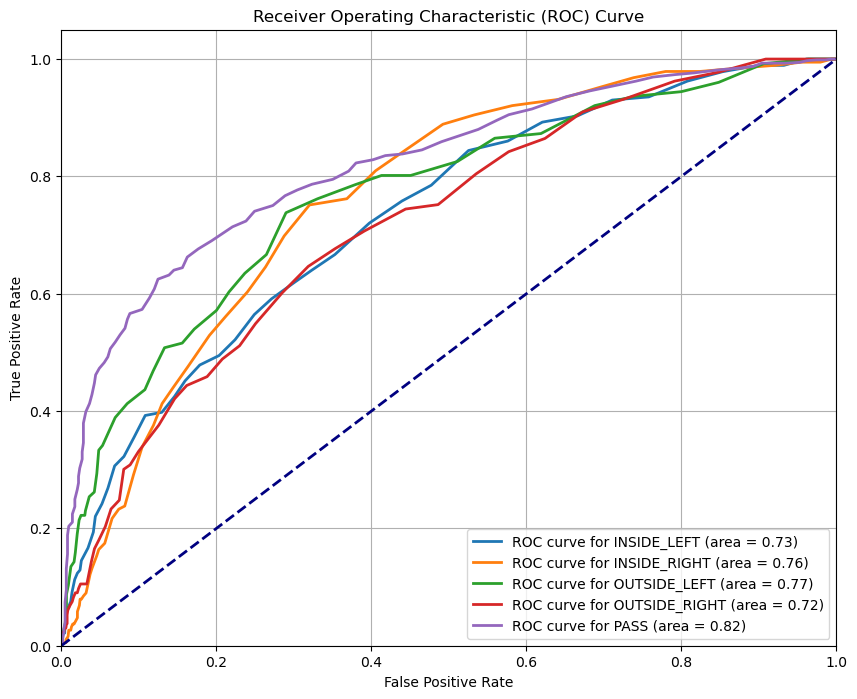

In [118]:
# RF Classifier with Team/Play-level PCA 
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Preprocess Play-Level Data
# Replace NA values in 'rushLocationType_clean' with 'PASS' for pass plays
temp_df['rushLocationType_clean'] = temp_df['rushLocationType_clean'].fillna('PASS')

# Encode target variable
label_encoder = LabelEncoder()
temp_df['target_encoded'] = label_encoder.fit_transform(temp_df['rushLocationType_clean'])

# Select categorical and numeric features for play-level data
categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

# Label encode categorical variables
for feature in categorical_features:
    temp_df[feature] = LabelEncoder().fit_transform(temp_df[feature])

# Normalize numeric features
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
scaler = StandardScaler()
temp_df[numeric_to_normalize] = scaler.fit_transform(temp_df[numeric_to_normalize])

# Combine processed features
play_X_prepared = temp_df[categorical_features + numeric_features].values
play_y_prepared = temp_df['target_encoded']

# Step 2: Perform Per-Team PCA on Tracking Data
# Define the number of principal components
n_components = 5

# Select relevant tracking features
tracking_features = ['x', 'y', 's', 'a', 'dir']

# Filter tracking data for valid plays
valid_plays = set(temp_df[['gameId', 'playId']].apply(tuple, axis=1))
filtered_tracking = temp_df_track[temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]

# Encode 'club' column in tracking data
filtered_tracking['club'] = LabelEncoder().fit_transform(filtered_tracking['club'])

# Perform PCA per team
aggregated_tracking_list = []
for team, group in filtered_tracking.groupby('club'):
    pca = PCA(n_components=n_components)
    team_tracking_pca = pca.fit_transform(group[tracking_features].fillna(0))  # Handle NaN by filling with 0

    # Create DataFrame for PCA components
    team_tracking_df = pd.DataFrame(team_tracking_pca, columns=[f'Team_{team}_PC{i+1}' for i in range(n_components)])
    team_tracking_df[['gameId', 'playId']] = group[['gameId', 'playId']].values

    # Aggregate PCA components by play (mean)
    aggregated_team_tracking = team_tracking_df.groupby(['gameId', 'playId']).mean().reset_index()
    aggregated_tracking_list.append(aggregated_team_tracking)

# Combine all team PCA results
aggregated_tracking = pd.concat(aggregated_tracking_list, ignore_index=True)

# Merge aggregated tracking data with play-level data
play_tracking_merged = temp_df.merge(aggregated_tracking, on=['gameId', 'playId'])

# Step 3: Prepare Features and Target
X = play_tracking_merged.drop(columns=['rushLocationType_clean', 'target_encoded', 'gameClock', 'gameId', 'playId'])
y = play_tracking_merged['target_encoded']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.fillna(0), y_train)  # Handle NaN by filling with 0

# Step 6: Train Random Forest Classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Step 7: Evaluate the Model
# Predict on the test set
y_pred = rf_classifier.predict(X_test.fillna(0))  # Handle NaN by filling with 0

# Classification report with category names
categories = label_encoder.inverse_transform(np.unique(y))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Feature Importance
feature_importances = rf_classifier.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance from Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Debugging: Display top important features
print("\nTop Features:\n")
print(importance_df.head(10))

# Step 9: Plot ROC Curve
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.arange(len(categories)))
y_score = rf_classifier.predict_proba(X_test.fillna(0))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {category} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


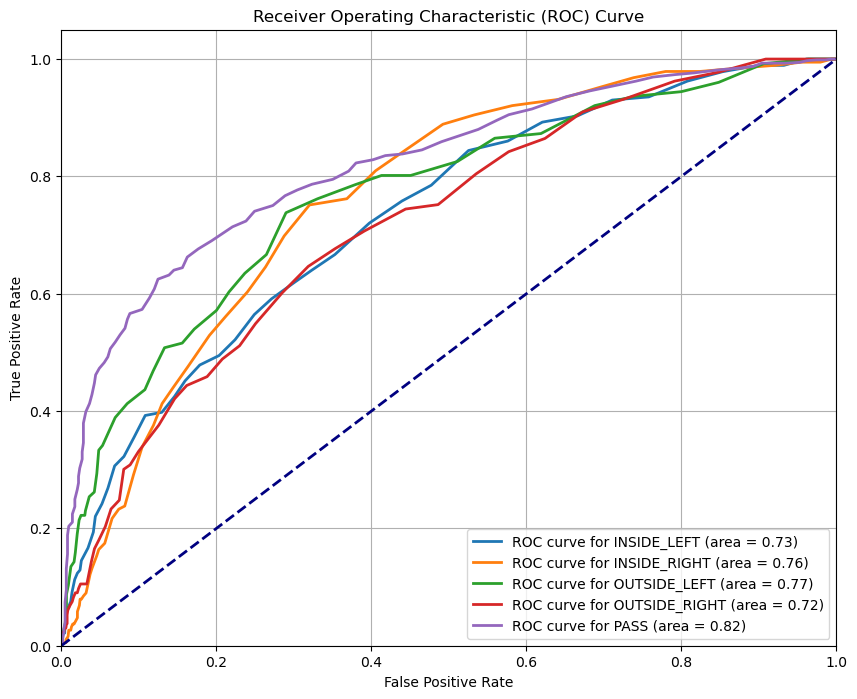

In [120]:
# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {category} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [102]:
# K-fold Cross-Validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report

# Define parameter grid, including max_features
param_grid = {
    'n_estimators': [100],  # Fixed number of trees for now
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None, 0.1, 0.2, 0.3, 0.5, 0.7],  # Evaluating number of features for splits
    'class_weight': ['balanced']
}

# Initialize a Stratified K-Fold cross-validator
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize the Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to the resampled training data
grid_search.fit(X_train_resampled, y_train_resampled)

# Extract the best parameters and score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validation Accuracy: {best_score:.4f}")

# Train the model with the best parameters
best_rf = grid_search.best_estimator_
best_rf.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on the test set
y_pred = best_rf.predict(X_test.fillna(0))  # Handle NaN by filling with 0
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))

# Optional: Feature importance visualization
import matplotlib.pyplot as plt
import pandas as pd

feature_importances = best_rf.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance from Best Random Forest")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

# Calculate AUC score for multi-class
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))  # Binarize test labels
y_score = best_rf.predict_proba(X_test.fillna(0))  # Predicted probabilities for AUC calculation

# Calculate overall AUC score using one-vs-rest strategy
average_auc = roc_auc_score(y_test_binarized, y_score, multi_class="ovr")

print(f"\nAverage AUC Score (One-vs-Rest): {average_auc:.4f}")


## XGBoost Classifier

In [107]:
# Baseline XGBoost Classifier
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Preprocess Play-Level Data
temp_df['rushLocationType_clean'] = temp_df['rushLocationType_clean'].fillna('PASS')

# Encode target variable
label_encoder = LabelEncoder()
temp_df['target_encoded'] = label_encoder.fit_transform(temp_df['rushLocationType_clean'])

# Select categorical and numeric features for play-level data
categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

# Label encode categorical variables
for feature in categorical_features:
    temp_df[feature] = LabelEncoder().fit_transform(temp_df[feature])

# Normalize numeric features
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
scaler = StandardScaler()
temp_df[numeric_to_normalize] = scaler.fit_transform(temp_df[numeric_to_normalize])

# Combine processed features
X = temp_df[categorical_features + numeric_features].values
y = temp_df['target_encoded']

# Step 2: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 4: Train XGBoost Classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Step 5: Evaluate the Model
# Predict on the test set
y_pred = xgb_classifier.predict(X_test)

# Classification report with category names
categories = label_encoder.inverse_transform(np.unique(y))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 6: Compute and Plot ROC-AUC
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.arange(len(categories)))
y_score = xgb_classifier.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC-AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(categories))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(categories)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(categories)

# Calculate macro-average AUC
macro_auc = auc(all_fpr, mean_tpr)

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {category} (area = {roc_auc[i]:.2f})')

# Plot macro-average ROC curve
plt.plot(all_fpr, mean_tpr, color='gold', lw=2, linestyle='--', label=f'Macro-Average ROC curve (area = {macro_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Debugging: Print AUC scores for each class and the macro-average
print("\nAUC Scores by Class:")
for i, category in enumerate(categories):
    print(f"{category}: {roc_auc[i]:.4f}")
print(f"\nMacro-Average AUC Score: {macro_auc:.4f}")


# Step 7: Feature Importance
feature_importances = xgb_classifier.feature_importances_
importance_df = pd.DataFrame({"Feature": categorical_features + numeric_features, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance from XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Debugging: Display top important features
print("\nTop Features:\n")
print(importance_df.head(10))


In [ ]:
# XGBoost with overall PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.preprocessing import label_binarize
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

# Step 1: Preprocess play-level data
temp_df['rushLocationType_clean'] = temp_df['rushLocationType_clean'].fillna('PASS')
label_encoder = LabelEncoder()
temp_df['target_encoded'] = label_encoder.fit_transform(temp_df['rushLocationType_clean'])
categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]
for feature in categorical_features:
    temp_df[feature] = LabelEncoder().fit_transform(temp_df[feature])
scaler = StandardScaler()
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
temp_df[numeric_to_normalize] = scaler.fit_transform(temp_df[numeric_to_normalize])
play_X_prepared = temp_df[categorical_features + numeric_features].values
play_y_prepared = temp_df['target_encoded']

# Step 2: Preprocess Tracking Data with PCA
n_components = 5
tracking_features = ['x', 'y', 's', 'a', 'dir']
valid_plays = set(temp_df[['gameId', 'playId']].apply(tuple, axis=1))
filtered_tracking = temp_df_track[temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]
pca = PCA(n_components=n_components)
tracking_X_pca = pca.fit_transform(filtered_tracking[tracking_features])
filtered_tracking['play_id_tuple'] = filtered_tracking[['gameId', 'playId']].apply(tuple, axis=1)
tracking_pca_df = pd.DataFrame(tracking_X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
tracking_pca_df['play_id_tuple'] = filtered_tracking['play_id_tuple'].values
aggregated_tracking = tracking_pca_df.groupby('play_id_tuple').mean().reset_index()
aggregated_tracking[['gameId', 'playId']] = pd.DataFrame(aggregated_tracking['play_id_tuple'].tolist(), index=aggregated_tracking.index)
aggregated_tracking = aggregated_tracking.drop(columns=['play_id_tuple'])
play_tracking_merged = temp_df.merge(aggregated_tracking, on=['gameId', 'playId'])

# Step 3: Prepare Features and Target
X = play_tracking_merged.drop(columns=['rushLocationType_clean', 'target_encoded', 'gameClock', 'gameId', 'playId'])
y = play_tracking_merged['target_encoded']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Step 6: Train XGBoost Classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Step 7: Evaluate the Model
y_pred = xgb_classifier.predict(X_test)
categories = label_encoder.inverse_transform(np.unique(y))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Compute and Plot ROC-AUC
# Binarize the output
y_test_binarized = label_binarize(y_test, classes=np.arange(len(categories)))
y_score = xgb_classifier.predict_proba(X_test)

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(categories)):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC-AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(categories))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(categories)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= len(categories)
macro_auc = auc(all_fpr, mean_tpr)

# Plot ROC Curve
plt.figure(figsize=(10, 8))
for i, category in enumerate(categories):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'ROC curve for {category} (area = {roc_auc[i]:.2f})')
plt.plot(all_fpr, mean_tpr, color='gold', lw=2, linestyle='--', label=f'Macro-Average ROC curve (area = {macro_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Output AUC scores
print("\nAUC Scores by Class:")
for i, category in enumerate(categories):
    print(f"{category}: {roc_auc[i]:.4f}")
print(f"\nMacro-Average AUC Score: {macro_auc:.4f}")


In [ ]:
# XGBoost with Team/Play-level PCA
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# Step 1: Preprocess Play-Level Data
# Replace NA values in 'rushLocationType_clean' with 'PASS' for pass plays
temp_df['rushLocationType_clean'] = temp_df['rushLocationType_clean'].fillna('PASS')

# Encode target variable
label_encoder = LabelEncoder()
temp_df['target_encoded'] = label_encoder.fit_transform(temp_df['rushLocationType_clean'])

# Select categorical and numeric features for play-level data
categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

# Label encode categorical variables
for feature in categorical_features:
    temp_df[feature] = LabelEncoder().fit_transform(temp_df[feature])

# Normalize numeric features
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
scaler = StandardScaler()
temp_df[numeric_to_normalize] = scaler.fit_transform(temp_df[numeric_to_normalize])

# Combine processed features
play_X_prepared = temp_df[categorical_features + numeric_features].values
play_y_prepared = temp_df['target_encoded']

# Step 2: Perform Per-Team PCA on Tracking Data
# Define the number of principal components
n_components = 5

# Select relevant tracking features
tracking_features = ['x', 'y', 's', 'a', 'dir']

# Filter tracking data for valid plays
valid_plays = set(temp_df[['gameId', 'playId']].apply(tuple, axis=1))
filtered_tracking = temp_df_track[temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]

# Encode 'club' column in tracking data
filtered_tracking['club'] = LabelEncoder().fit_transform(filtered_tracking['club'])

# Perform PCA per team
aggregated_tracking_list = []
for team, group in filtered_tracking.groupby('club'):
    pca = PCA(n_components=n_components)
    team_tracking_pca = pca.fit_transform(group[tracking_features].fillna(0))  # Handle NaN by filling with 0

    # Create DataFrame for PCA components
    team_tracking_df = pd.DataFrame(team_tracking_pca, columns=[f'Team_{team}_PC{i+1}' for i in range(n_components)])
    team_tracking_df[['gameId', 'playId']] = group[['gameId', 'playId']].values

    # Aggregate PCA components by play (mean)
    aggregated_team_tracking = team_tracking_df.groupby(['gameId', 'playId']).mean().reset_index()
    aggregated_tracking_list.append(aggregated_team_tracking)

# Combine all team PCA results
aggregated_tracking = pd.concat(aggregated_tracking_list, ignore_index=True)

# Merge aggregated tracking data with play-level data
play_tracking_merged = temp_df.merge(aggregated_tracking, on=['gameId', 'playId'])

# Step 3: Prepare Features and Target
X = play_tracking_merged.drop(columns=['rushLocationType_clean', 'target_encoded', 'gameClock', 'gameId', 'playId'])
y = play_tracking_merged['target_encoded']

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 5: Handle Class Imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train.fillna(0), y_train)  # Handle NaN by filling with 0

# Step 6: Train XGBoost Classifier
xgb_classifier = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
xgb_classifier.fit(X_train_resampled, y_train_resampled)

# Step 7: Evaluate the Model
# Predict on the test set
y_pred = xgb_classifier.predict(X_test.fillna(0))  # Handle NaN by filling with 0

# Classification report with category names
categories = label_encoder.inverse_transform(np.unique(y))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=categories))

# Accuracy score
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")

# Step 8: Feature Importance
feature_importances = xgb_classifier.feature_importances_
importance_df = pd.DataFrame({"Feature": X.columns, "Importance": feature_importances}).sort_values(by="Importance", ascending=False)

# Plot Feature Importance
plt.figure(figsize=(12, 6))
plt.bar(importance_df["Feature"], importance_df["Importance"])
plt.xticks(rotation=90)
plt.title("Feature Importance from XGBoost")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()

# Debugging: Display top important features
print("\nTop Features:\n")
print(importance_df.head(10))


## GRU

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GRU, Concatenate, Dropout, Masking
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.losses import CategoricalCrossentropy
import matplotlib.pyplot as plt

# Step 1: Preprocess play-level data
temp_df['rushLocationType_clean'] = temp_df['rushLocationType_clean'].fillna('PASS')
label_encoder = LabelEncoder()
temp_df['target_encoded'] = label_encoder.fit_transform(temp_df['rushLocationType_clean'])

categorical_features = ['offenseFormation', 'receiverAlignment', 'possessionTeam', 'defensiveTeam', 'yardlineSide']
numeric_features = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential',
    'isLeading', 'isRedZone', 'shortYardage', 'secondAndLong', 'thirdAndLong', 'fourthQuarter', 'twoMinuteDrill'
]

for feature in categorical_features:
    temp_df[feature] = LabelEncoder().fit_transform(temp_df[feature])

scaler = StandardScaler()
numeric_to_normalize = [
    'down', 'yardsToGo', 'quarter', 'preSnapHomeScore', 'preSnapVisitorScore', 'yardlineNumber',
    'preSnapHomeTeamWinProbability', 'preSnapVisitorTeamWinProbability', 'scoreDifferential'
]
temp_df[numeric_to_normalize] = scaler.fit_transform(temp_df[numeric_to_normalize])

play_X_prepared = temp_df[categorical_features + numeric_features].values
play_y_prepared = temp_df['target_encoded']

# Step 2: Prepare tracking data with percentile-based sequence length
tracking_features = ['x', 'y', 's', 'a', 'dir']

valid_plays = set(temp_df[['gameId', 'playId']].apply(tuple, axis=1))
filtered_tracking = temp_df_track[temp_df_track[['gameId', 'playId']].apply(tuple, axis=1).isin(valid_plays)]

# Determine the 95th percentile for sequence length
play_lengths = filtered_tracking.groupby(['gameId', 'playId']).size()
sequence_length = int(play_lengths.quantile(0.95))
print(f"Using sequence length: {sequence_length}")

# Downsample longer plays
def downsample_play(play_data, target_length):
    if len(play_data) > target_length:
        factor = len(play_data) / target_length
        return play_data[::int(factor)]
    return play_data

grouped_tracking = filtered_tracking.groupby(['gameId', 'playId']).apply(
    lambda group: downsample_play(group[tracking_features].values, sequence_length)
)

# Pad sequences to the new fixed sequence length
tracking_sequences = [
    np.pad(seq, ((0, max(0, sequence_length - len(seq))), (0, 0)), mode='constant')[:sequence_length]
    for seq in grouped_tracking
]
tracking_X_prepared = np.array(tracking_sequences)

# Match targets to tracking data
tracking_targets = temp_df.set_index(['gameId', 'playId']).loc[grouped_tracking.index]['target_encoded']
tracking_y_prepared = tracking_targets.values

# Step 3: Use focal loss for class imbalance
import tensorflow as tf

def focal_loss(alpha=0.25, gamma=2.0):
    def loss(y_true, y_pred):
        ce_loss = CategoricalCrossentropy()(y_true, y_pred)
        p_t = tf.reduce_sum(y_true * y_pred, axis=-1)
        modulating_factor = tf.pow(1.0 - p_t, gamma)
        return alpha * modulating_factor * ce_loss
    return loss

# One-hot encode targets
play_y_prepared = to_categorical(play_y_prepared)
tracking_y_prepared = to_categorical(tracking_y_prepared)

# Split data into training and testing sets
play_X_train, play_X_test, tracking_X_train, tracking_X_test, y_train, y_test = train_test_split(
    play_X_prepared, tracking_X_prepared, play_y_prepared, test_size=0.2, random_state=42
)

# Step 4: Define the GRU-based neural network with masking
play_input = Input(shape=(play_X_train.shape[1],), name="Play_Input")
play_dense = Dense(64, activation="relu")(play_input)

tracking_input = Input(shape=(sequence_length, len(tracking_features)), name="Tracking_Input")
masked_tracking_input = Masking(mask_value=0)(tracking_input)  # Mask padding
tracking_gru = GRU(64, return_sequences=False)(masked_tracking_input)
tracking_dense = Dense(32, activation="relu")(tracking_gru)

combined = Concatenate()([play_dense, tracking_dense])

dense_1 = Dense(64, activation="relu")(combined)
dense_2 = Dense(32, activation="relu")(dense_1)
dropout = Dropout(0.3)(dense_2)
output = Dense(play_y_prepared.shape[1], activation="softmax")(dropout)

model = Model(inputs=[play_input, tracking_input], outputs=output)
model.compile(optimizer="adam", loss=focal_loss(), metrics=["accuracy"])

# Step 5: Train the model
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

history = model.fit(
    [play_X_train, tracking_X_train], y_train,
    validation_data=([play_X_test, tracking_X_test], y_test),
    epochs=50, batch_size=32, callbacks=[early_stopping]
)

# Evaluate the model
loss, accuracy = model.evaluate([play_X_test, tracking_X_test], y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.4f}")

# Classification report
y_pred = np.argmax(model.predict([play_X_test, tracking_X_test]), axis=1)
y_true = np.argmax(y_test, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

## Baseline Classifiers

In [114]:
from sklearn.dummy import DummyClassifier

# Use a random strategy for classification
random_baseline = DummyClassifier(strategy="uniform", random_state=42)
random_baseline.fit(X_train, y_train)
random_y_pred = random_baseline.predict(X_test)

# Evaluate the random baseline
print("Random Baseline Classification Report:")
print(classification_report(y_test, random_y_pred, target_names=label_encoder.classes_))

Random Baseline Classification Report:
               precision    recall  f1-score   support

  INSIDE_LEFT       0.11      0.18      0.14       141
 INSIDE_RIGHT       0.12      0.17      0.14       144
 OUTSIDE_LEFT       0.11      0.23      0.15        97
OUTSIDE_RIGHT       0.08      0.17      0.11       102
         PASS       0.50      0.19      0.28       547

     accuracy                           0.19      1031
    macro avg       0.19      0.19      0.16      1031
 weighted avg       0.32      0.19      0.21      1031



Naive Bayes Classification Report:
               precision    recall  f1-score   support

  INSIDE_LEFT       0.21      0.17      0.19       141
 INSIDE_RIGHT       0.18      0.05      0.08       144
 OUTSIDE_LEFT       0.11      0.13      0.12        97
OUTSIDE_RIGHT       0.10      0.24      0.14       102
         PASS       0.66      0.63      0.64       547

     accuracy                           0.40      1031
    macro avg       0.25      0.24      0.23      1031
 weighted avg       0.42      0.40      0.40      1031

Naive Bayes Test Accuracy: 0.3986
Naive Bayes AUC Score (Macro-Averaged): 0.6126


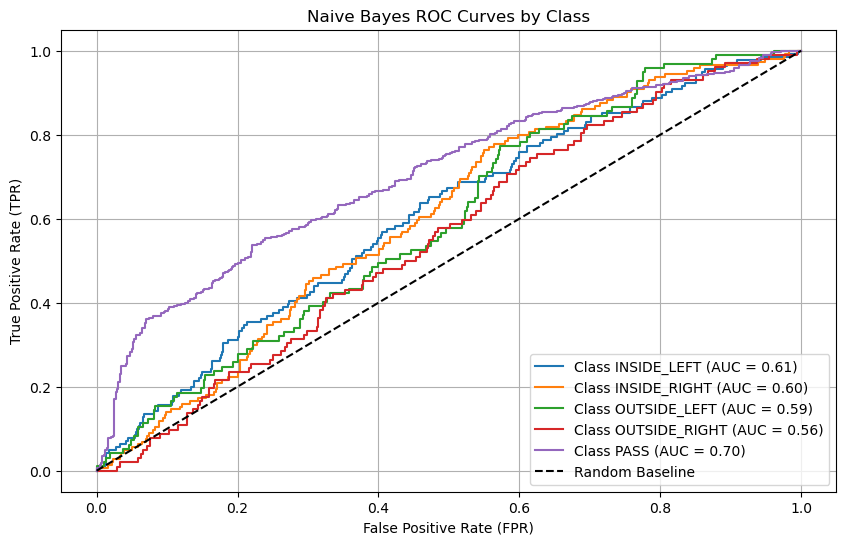

In [116]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score

# Initialize the Naive Bayes classifier
naive_bayes_classifier = GaussianNB()

# Fit the classifier on the training data
naive_bayes_classifier.fit(X_train, y_train)

# Predict on the test data
naive_bayes_y_pred = naive_bayes_classifier.predict(X_test)

# Evaluate the model
print("Naive Bayes Classification Report:")
print(classification_report(y_test, naive_bayes_y_pred, target_names=label_encoder.classes_))

# Calculate accuracy
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_y_pred)
print(f"Naive Bayes Test Accuracy: {naive_bayes_accuracy:.4f}")

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize the test labels for multi-class AUC
y_test_binarized = label_binarize(y_test, classes=np.unique(y_test))  # Ensure multi-class handling
naive_bayes_y_proba = naive_bayes_classifier.predict_proba(X_test)

# Calculate AUC score (macro average for multi-class)
auc_score = roc_auc_score(y_test_binarized, naive_bayes_y_proba, average='macro', multi_class='ovr')
print(f"Naive Bayes AUC Score (Macro-Averaged): {auc_score:.4f}")

# Plot ROC curves for each class
plt.figure(figsize=(10, 6))
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], naive_bayes_y_proba[:, i])
    plt.plot(fpr, tpr, label=f'Class {class_name} (AUC = {roc_auc_score(y_test_binarized[:, i], naive_bayes_y_proba[:, i]):.2f})')

plt.plot([0, 1], [0, 1], 'k--', label="Random Baseline")
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Naive Bayes ROC Curves by Class")
plt.legend(loc="lower right")
plt.grid()
plt.show()